In [1]:
import torch, torch.nn as nn
import numpy as np, matplotlib.pyplot as plt
from tqdm.auto import tqdm

def seq_mlp(init, mlp, fin, act):
    modules = [nn.Linear(init, mlp[0]), act]
    for i in range(len(mlp) - 1):
        modules.append(nn.Linear(mlp[i], mlp[i+1]))
        modules.append(act)

    modules.append(nn.Linear(mlp[-1], fin)) #self.spl for spline

    return modules

c:\Users\Hanse Kim\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
class EvalEig(nn.Module):
    def __init__(self, para):
        super().__init__()
        self.rn = para['rn']
        self.rm = para['rm']
        self.r_dsc = torch.linspace(self.rm/self.rn, self.rm, self.rn, requires_grad=True)
    
    def fixed_tr(self, para_ptl, ptl_form):
        coeffs_tr = torch.ones(self.batch_dim, 1)
        r_dsc_d = self.r_dsc.view(1,-1)
        if ptl_form == "coulomb":
            #coeffs_tr = 1 + torch.rand(self.batch_dim, 1)/10
            return -coeffs_tr*para_ptl/r_dsc_d
        elif ptl_form == "yukawa":
            return coeffs_tr*para_ptl*(-1/r_dsc_d + torch.exp(-r_dsc_d/40)*r_dsc_d/120)

    def set_evl(self, evl):
        self.evl = evl
        
        ptl_modules = seq_mlp(init = 1, mlp = para['mlp'], fin = 1, act = nn.ReLU())
        self.ptl_mlp = nn.Sequential(*ptl_modules)
        rad_modules = seq_mlp(init = 1, mlp = para['mlp'], fin = evl.shape[0], act = nn.Tanh())
        self.rad_mlp = nn.Sequential(*rad_modules)        

    def grad_nn(self, x, y):
        grad_list = []
        for i in range(y.shape[0]):
            grad = torch.autograd.grad(
                outputs = y[i], inputs = x, grad_outputs = torch.ones_like(y[i]), 
                retain_graph = True, create_graph = True)[0]
            grad_list.append(grad)
        grad = torch.stack(grad_list)
        return grad

    def spectral_err(self, rad, ptl, evl):
        evl_rs = evl.view(-1,1)
        #ptl_rs = ptl(self.r_dsc.view(-1,1)).view(1,-1)
        ptl_rs = -1/self.r_dsc
        rad_rs = rad(self.r_dsc.view(-1,1)).transpose(0,1)

        # boundary conditions on rad_rs
        #rad_rs = rad_rs * 

        rad_norm = rad_rs / torch.sqrt(torch.sum(rad_rs**2, dim=1).view(-1,1)*self.rm/self.rn)
        #print("u(r) : ", rad_rs.shape, rad_rs)

        rad_d = self.grad_nn(self.r_dsc, rad_norm)
        #print("u'(r) : ", rad_d.shape, rad_d)

        rad_dd = self.grad_nn(self.r_dsc, rad_d)
        #print("u''(r) : ", rad_dd.shape, rad_dd)
        
        #plt.figure()
        #plt.plot(r_dsc.detach(), rad_rs[0].detach())
        #plt.plot(r_dsc.detach(), rad_d[0].detach())
        #plt.plot(r_dsc.detach(), rad_dd[0].detach())
        #plt.show()

        # rad output : evl_N x self.rn
        error_mtr = -rad_dd + ptl_rs * rad_norm - evl_rs * rad_norm

        return ptl_rs, rad_norm, error_mtr

    def forward(self):
        ptl_md, rad_md, error_mtr = self.spectral_err(self.rad_mlp, self.ptl_mlp, self.evl)
        error = torch.sqrt(torch.sum(error_mtr**2))

        return ptl_md, rad_md, error

In [70]:
para = {
        'rm' : 100,
        'rn' : 2000,

        # model
        'mlp' : [10,10,10],

        # training
        'epoch' : 1000,
        'lr' : 1e-2,

        # loss regularisation
        'reg0' : 1,
        'reg1' : 0,
        'reg2' : 1e4,
}

model = EvalEig(para)

evl_tr = -torch.arange(1,4).to(torch.float32)**(-2)/4
model.set_evl(evl_tr)

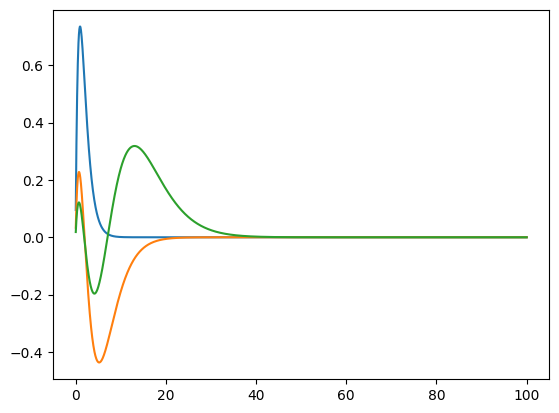

In [77]:
r = model.r_dsc

rad_tr = torch.stack([2*r*torch.exp(-r), 1/np.sqrt(2)*r*(1-r/2)*torch.exp(-r/2), 2/np.sqrt(27)*r*(1-2*r/3+2*r**2/27)*torch.exp(-r/3)])
rad_tr_norm = rad_tr / torch.sqrt(torch.sum(rad_tr**2, dim=1).view(-1,1)*model.rm/model.rn)

plt.figure()
plt.plot(r.detach(), rad_tr_norm[0].detach())
plt.plot(r.detach(), rad_tr_norm[1].detach())
plt.plot(r.detach(), rad_tr_norm[2].detach())

In [80]:
optimiser = torch.optim.Adam(model.parameters(), lr = para['lr'])
epochs = para['epoch']
pbar = tqdm(range(epochs), desc='Progress', total=epochs, leave = True, position=0, colour='blue')

for e in range(epochs):
    rad_md = model.ptl_mlp(r.view(-1,1))
    print(rad_md.shape)
    print(rad_tr_norm.shape)
    loss = nn.L1Loss()(rad_md, rad_tr_norm)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
    pbar.update()

Progress:   0%|          | 0/1000 [00:19<?, ?it/s]

torch.Size([2000, 1])
torch.Size([3, 2000])



c:\Users\Hanse Kim\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([3, 2000])) that is different to the input size (torch.Size([2000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (2000) must match the size of tensor b (3) at non-singleton dimension 0

: 

In [ ]:
pbar = tqdm(range(epochs), desc='Progress', total=epochs, leave = True, position=0, colour='blue')
loss_list = [[],[],[]]

for e in range(epochs):
    #with torch.autograd.detect_anomaly():
    ptl_md, rad_md, loss0 = model()
    
    loss1 = torch.abs(ptl_md[-1])
    loss2 = torch.sqrt(torch.sum(rad_md[:,0]**2 + rad_md[:,-1]**2))
    loss = para['reg0']*loss0 + para['reg1']*loss1 + para['reg2']*loss2

    loss_list[0].append(loss0.item())
    loss_list[1].append(loss1.item())
    loss_list[2].append(loss2.item())

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    pbar.update()
    #print(loss.item())

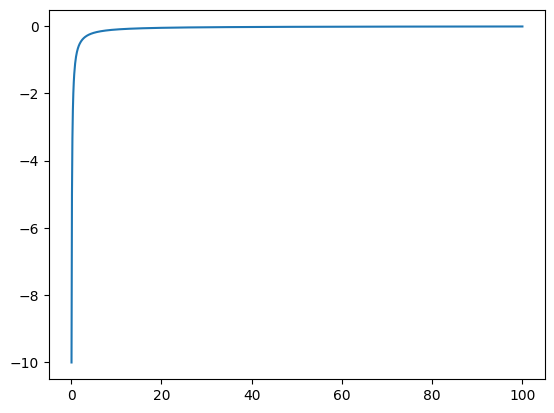

In [38]:
plt.figure()
plt.plot(model.r_dsc.detach(), ptl_md.detach())
plt.show()

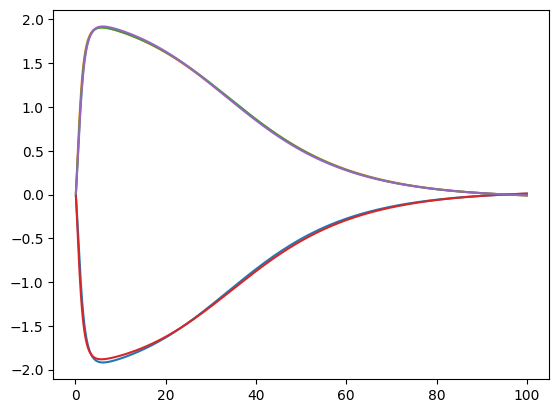

In [56]:
plt.figure()
plt.plot(model.r_dsc.detach(), rad_md[0].detach())
plt.plot(model.r_dsc.detach(), rad_md[1].detach())
plt.plot(model.r_dsc.detach(), rad_md[2].detach())
plt.plot(model.r_dsc.detach(), rad_md[3].detach())
plt.plot(model.r_dsc.detach(), rad_md[4].detach())
plt.show()

12.780112266540527 0.009999999776482582 0.048419855535030365


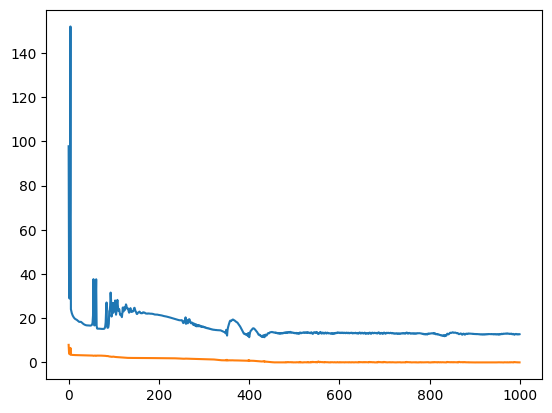

In [57]:
plt.figure()
j = 0
print(loss0.item(),loss1.item(),loss2.item())
plt.plot(np.arange(j,epochs), loss_list[0][j:])
#plt.plot(np.arange(j,epochs), loss_list[1][j:])
plt.plot(np.arange(j,epochs), loss_list[2][j:])